In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlencode
import requests
import pingouin as pg
import scipy.stats as ss
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import norm

# Задание 1

#### Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [24]:
df_reg = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-zelenko/shared/problem1-reg_data.csv', sep=';')
df_auth = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-k-zelenko/shared/problem1-auth_data.csv', sep=';')

In [25]:
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [26]:
df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Дата в 2-х датасетах представлена в формате Unix. Приведем дату к формату '%Y-%m-%d', посмотрим на размер данных, и на исследуемый промежуток времени.

In [27]:
df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts'],unit='s')

In [28]:
df_reg['reg_ts'] = df_reg['reg_ts'].dt.floor('D')

In [29]:
df_reg.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


In [30]:
df_reg.shape[0]

1000000

In [31]:
df_reg['uid'].nunique()

1000000

In [32]:
df_reg['reg_ts'].min()

Timestamp('1998-11-18 00:00:00')

In [33]:
df_reg['reg_ts'].max()

Timestamp('2020-09-23 00:00:00')

In [34]:
df_auth['auth_ts'] = pd.to_datetime(df_auth['auth_ts'],unit='s')

In [35]:
df_auth['auth_ts'] = df_auth['auth_ts'].dt.floor('D')

In [36]:
df_auth.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


In [37]:
df_auth.shape[0]

9601013

In [38]:
df_auth['auth_ts'].min()

Timestamp('1998-11-18 00:00:00')

In [39]:
df_auth['auth_ts'].max()

Timestamp('2020-09-23 00:00:00')

Создадим функию для расчета retention игроков по дням от даты регистрации.

In [40]:
def retention(registration, authorization, reg_date, last_date):
    """1.Объединяем таблицы в одну, чтобы видеть дату регистрации игроков и дату retention
       2.Считаем количество прошедших дней от даты регистрации игрока до даты захода в игру
       3.Задаем когорты по дате регистрации игроков
       4.Создаем фильтр по дате
       5.Строим сводную таблицу
       6.Визуализируем полученные данные
       """
   
    df_merge = df_reg.merge(df_auth, on='uid') 
    
    df_merge['days_from_reg'] = (df_merge['auth_ts'] - df_merge['reg_ts']).dt.days 
    
    cohort = df_merge.groupby(['reg_ts', 'days_from_reg'], as_index=False).agg({'uid': 'nunique'}) 
    
    cohort_by_date = cohort.query("reg_ts >= @reg_date & reg_ts <= @last_date") 
    
    cohort_table = cohort_by_date.pivot_table(index='reg_ts', columns='days_from_reg', values='uid')
    cohort_table_percent = cohort_table.divide(cohort_table[0], axis=0).round(3)
    del cohort_table_percent[0]
    
    plt.figure(figsize=(30, 30))
    ax = sns.heatmap(cohort_table_percent, annot=True, fmt='.2%', cbar=False)
    ax.set_yticklabels(pd.DataFrame(cohort_table_percent).reset_index().reg_ts.astype(str), rotation=0)
    ax.set_title('Retention from {} to {}'.format(reg_date, last_date), fontsize=25)
    sns.despine()
    
    return cohort_table

Проверим работоспособность функции, для примера возьмем с данных последний месяц регистрации игроков

days_from_reg,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-08-23,1562.0,39.0,60.0,76.0,77.0,109.0,128.0,89.0,80.0,71.0,...,69.0,53.0,61.0,49.0,57.0,65.0,45.0,48.0,53.0,28.0
2020-08-24,1565.0,28.0,65.0,67.0,80.0,90.0,119.0,94.0,77.0,81.0,...,57.0,54.0,70.0,49.0,51.0,49.0,49.0,44.0,20.0,NaN
2020-08-25,1567.0,31.0,69.0,75.0,89.0,83.0,83.0,98.0,58.0,90.0,...,56.0,51.0,51.0,69.0,44.0,49.0,50.0,36.0,NaN,NaN
2020-08-26,1570.0,23.0,54.0,66.0,71.0,101.0,103.0,94.0,72.0,68.0,...,67.0,51.0,43.0,46.0,44.0,43.0,26.0,NaN,NaN,NaN
2020-08-27,1573.0,26.0,53.0,75.0,82.0,87.0,97.0,90.0,68.0,85.0,...,47.0,47.0,61.0,53.0,43.0,23.0,NaN,NaN,NaN,NaN
2020-08-28,1575.0,32.0,72.0,83.0,75.0,99.0,98.0,86.0,88.0,83.0,...,74.0,64.0,45.0,58.0,40.0,NaN,NaN,NaN,NaN,NaN
2020-08-29,1578.0,40.0,59.0,73.0,90.0,87.0,110.0,90.0,72.0,95.0,...,67.0,55.0,56.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-30,1580.0,29.0,55.0,62.0,85.0,94.0,104.0,88.0,68.0,68.0,...,64.0,59.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-31,1583.0,29.0,58.0,67.0,81.0,109.0,103.0,106.0,76.0,85.0,...,44.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


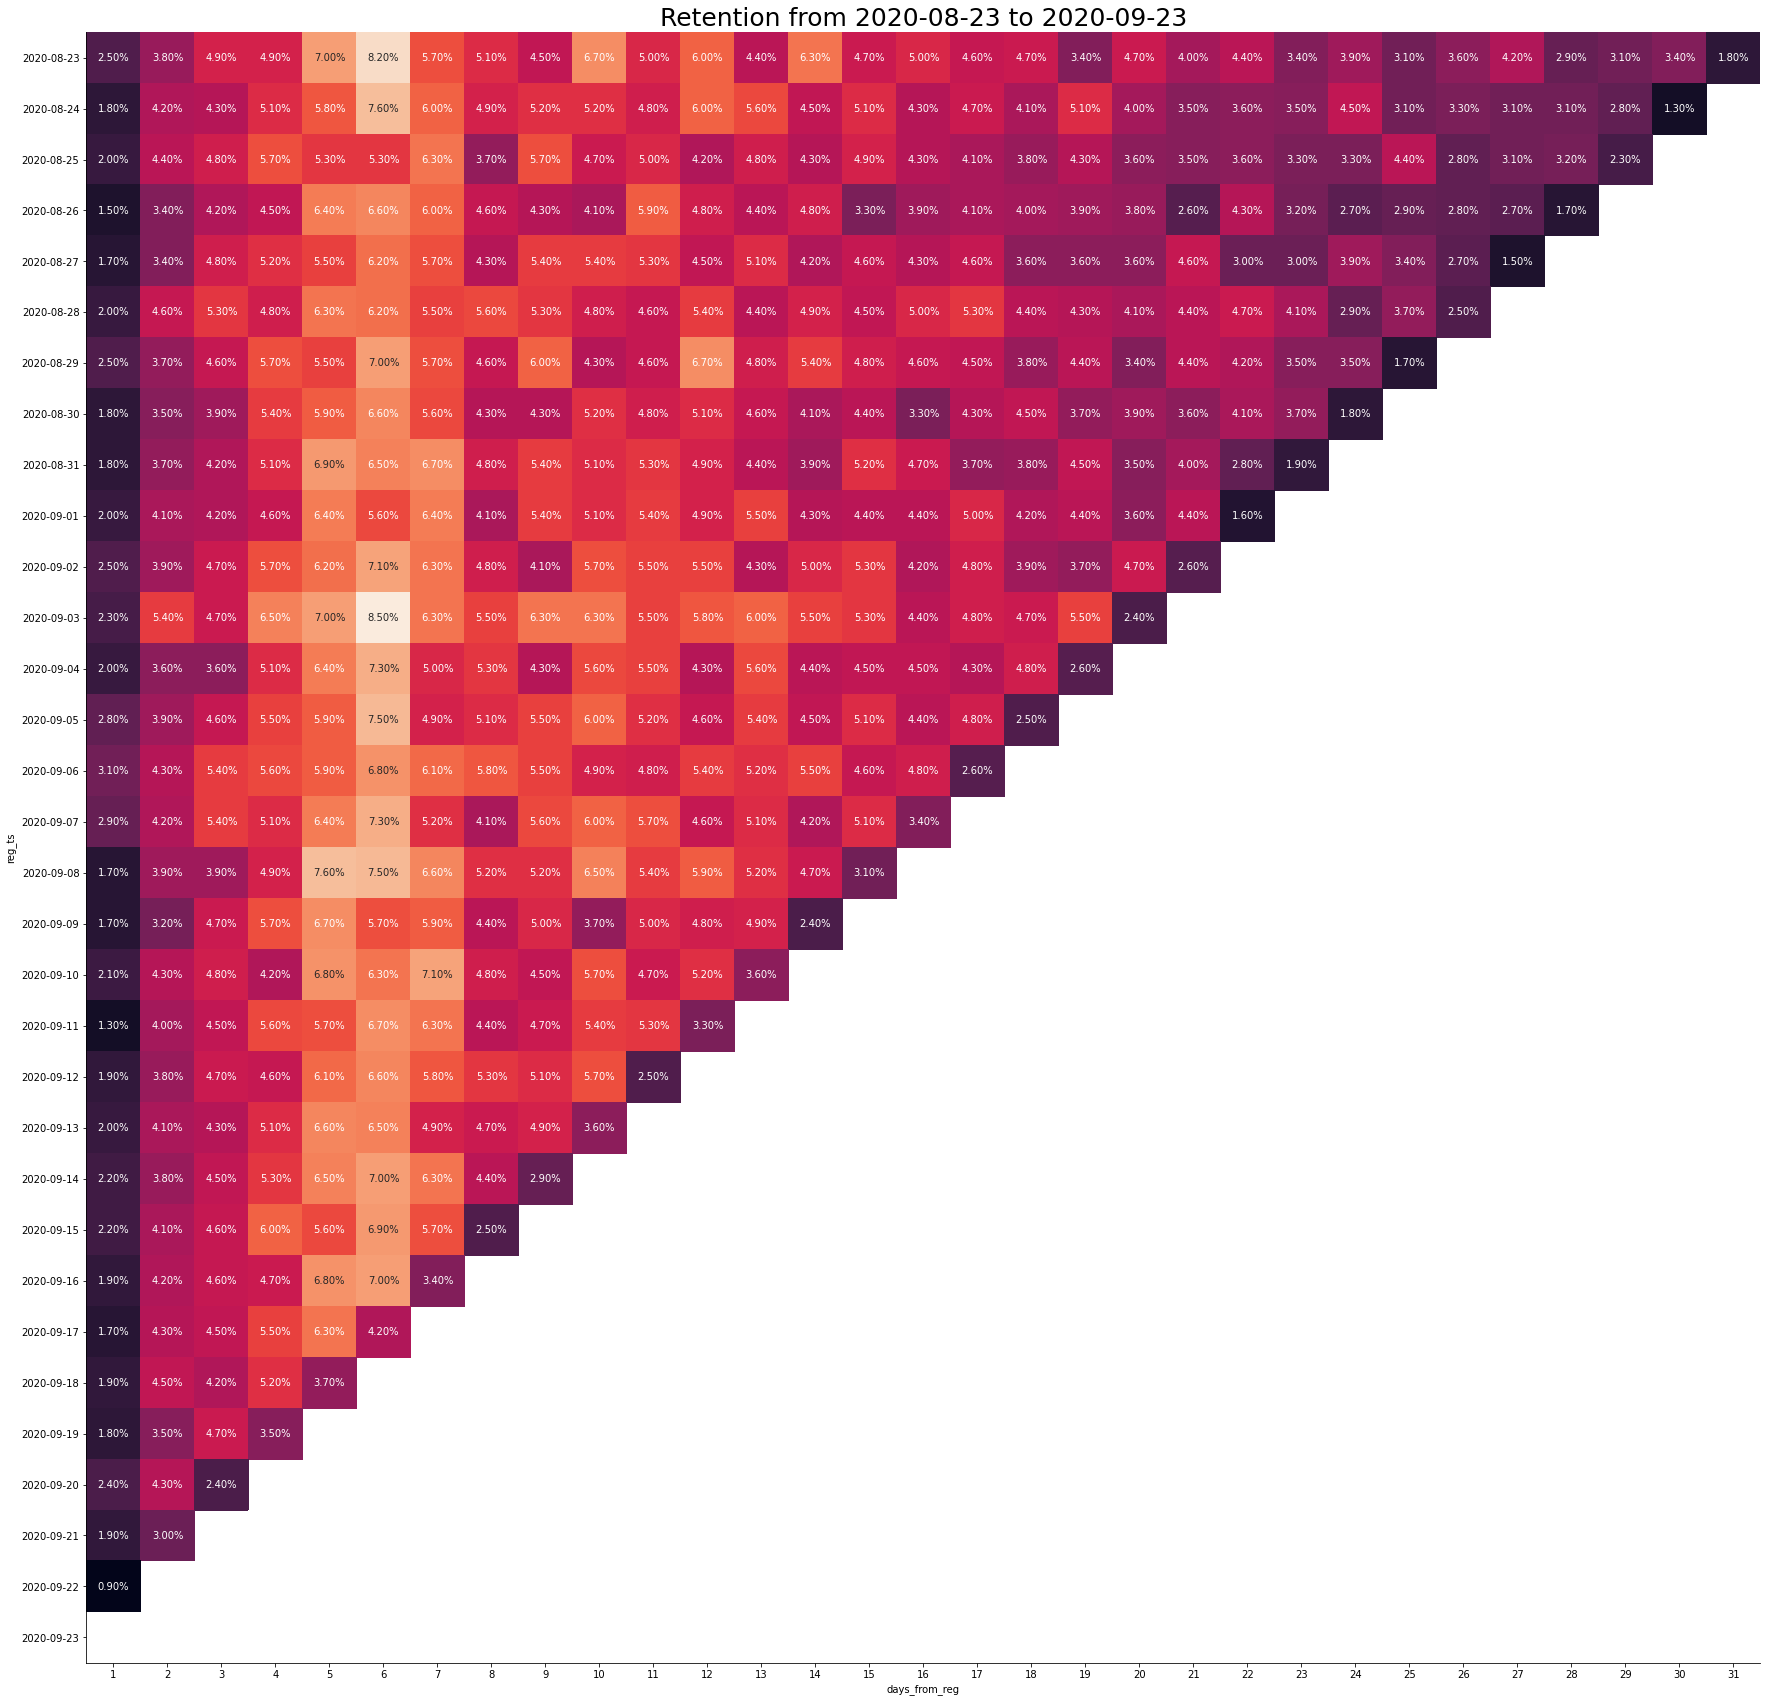

In [41]:
retention(df_reg, df_auth, '2020-08-23', '2020-09-23')

Согласно полученному графику, самый высокий retention у когорты 2020-09-03 на 6-й день после регистраци - 8,5%.

# Задание 2

#### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Загрузим файл с яндекс диска

In [95]:
df_data = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

In [96]:
def download(url):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=url))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [97]:
df = pd.read_csv(download(df_data), sep=';')

In [98]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Перед нами таблица с результатами A/B-теста, в котором провели эксперимент по увеличению дохода с помощью акционных предложений. Чтобы понять, стали ли мы больше зарабатывать с пользователя или нет, нужно сравнить результат между тестовой и контрольной группами.

Нулевая гипотеза - различия по доходу между группами не выявлены, альтернативная гипотеза - выявлены различия по доходу между группами.

Изучим исходные данные

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [100]:
df.revenue.min()

0

In [101]:
df.groupby('testgroup').agg({'user_id': 'count'}) #количество игроков в каждой группе

,user_id
testgroup,
a,202103
b,202667


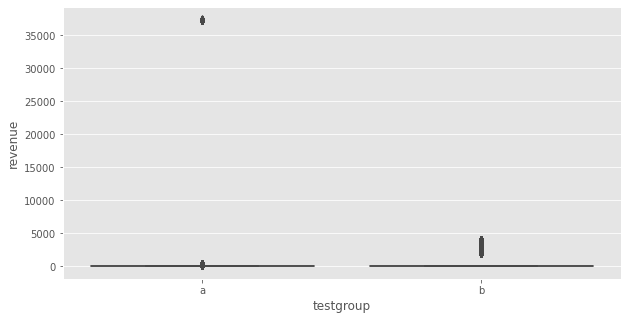

In [102]:
#Посторим боксплот
plt.figure(figsize = (10,5))
sns.boxplot(x='testgroup', y='revenue', data=df, order=['a', 'b'])

Видим,что график боксплот не презентативный, т.к. контрольная группа имеет большие выбросы. 

Разделим датасет на 2 группы и отберем только платящих игроков, и выведим основные показатели 

In [124]:
df_a_group = df.query("testgroup == 'a' and revenue > 0 and revenue < 35000")

In [104]:
df_a_group.revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [116]:
df_b_group = df.query("testgroup == 'b' and revenue > 0")

In [117]:
df_b_group.revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Видно что в контрольной группе среднее и медианное значение сильно отличаются, а в тестовой группе они примерно одинаковы, так же в контрольной группе максимальное значение во много раз отличается от остальных показателей, из этого можно предположить, что в данных группы "а" присутствуют выбросы.

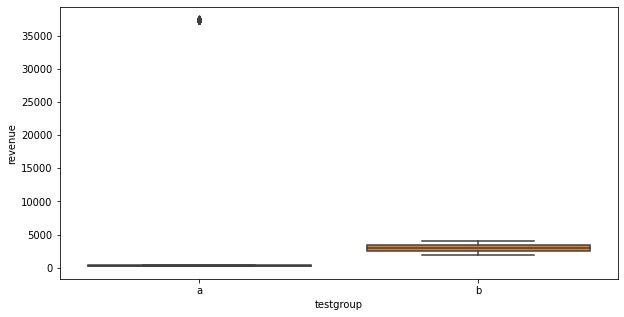

In [23]:
#Посторим боксплот только по платящим пользователям 
plt.figure(figsize = (10,5))
sns.boxplot(x='testgroup', y='revenue', data=df.query('revenue > 0'), order=['a', 'b'])

Боксплот и в данном случае не показателен, т.к. присутствуют большие выбросы в группе "а"

Для дальнейшего анализа необходимо проверить гипотезу о том, что  распределение соответствует нормальному. Построим для каждой группы distplot, qqplot и проведем тест для проверки нормальности распределения.

In [106]:
df_a_group = df_a_group.revenue

In [107]:
df_b_group = df_b_group.revenue

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


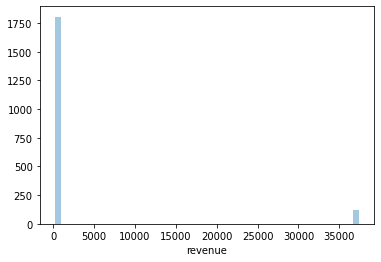

In [26]:
sns.distplot(df_a_group, kde=False)

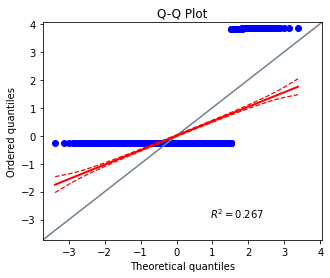

In [27]:
pg.qqplot(df_a_group, dist='norm')

In [28]:
ss.shapiro(df_a_group)

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

По графикам видно, что контрольная группа не симметрична, не имеет нормальное распределение. Почти все показатели собрались около 0 значения, а в право уходят выбросы, которые наблюдали в боксплоте. И это подтверждается тестом на нормальность: распределение отклоняется от нормального.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


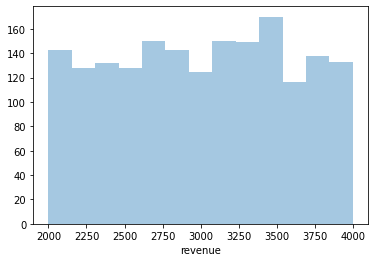

In [29]:
sns.distplot(df_b_group, kde=False)

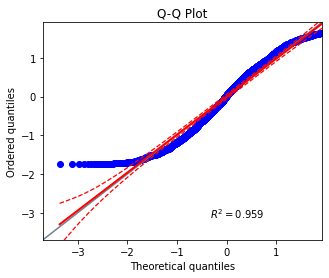

In [30]:
pg.qqplot(df_b_group, dist='norm')

In [31]:
ss.shapiro(df_b_group)

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

По тестовой группе также наблюдаем ненормальное распределение, нет симметрии. И тест показывает р-уровень значимости меньше 0.05: распределение отклоняется от нормального.

In [32]:
df.query("testgroup == 'a' and revenue > 35000").user_id.count()

123

In [33]:
df.query("testgroup == 'a' and revenue > 35000").revenue.sum() / df.query("testgroup == 'a'").revenue.sum() * 100

89.37077665950378

123 игрока из контрольной группы совершили покупки на сумму более 35000 каждый. Мы не можем считать данные по этим 123 пользователям выбросами, т.к. они составляют 89.37% от общего дохода контрольной группы.

Т.к. распределение между группами отклоняется от нормального и мы не можем преобразовать наши данные, выбросив из выборки 123 значения, то это позволяет провести бутстрап(bootstrap) анализ для подтверждения нулевой гипотезы об отсутствии различия в доходе между группами.

In [34]:
def get_bootstrap(
    data_column_1,
    data_column_2, 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95
):
    
    """Функция для проверки гипотезы с помощью бутстрапа"""
    
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

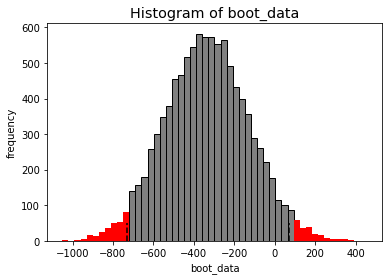

{'quants':                 0
 0.025 -729.619541
 0.975   70.029098,
 'p_value': 0.10232957409923947}

In [35]:
get_bootstrap(
    df_a_group,
    df_b_group,
    boot_it = 10000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95
)

Доверительный интервал: от -729.62 до 70,03. Полученный интервал включает 0 и р>0,05, это значит, что увеличение дохода статистически не значимое (принимается нулевая гипотеза). Но принимая во внимание, что распределение отклоняется от нормального, правильно использовать на этих данных не статистику mean, а median.

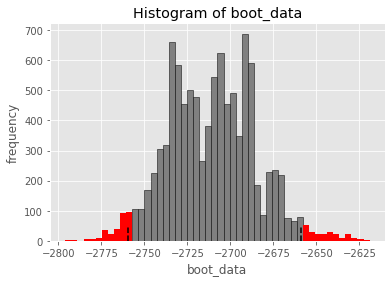

{'quants':             0
 0.025 -2759.5
 0.975 -2659.0,
 'p_value': 0.0}

In [36]:
get_bootstrap(
    df_a_group,
    df_b_group,
    boot_it = 10000,
    statistic = np.median,
    bootstrap_conf_level = 0.95
)

Доверительный интервал: от -2759,5 до -2659,0. Полученный интервал не включает 0 и р<0.05, это означает, что увеличение дохода статистически значимое (принимается альтернативная гипотеза). Ситуация получилась неопределенная, и для того, чтобы не совершить ошибку первого рода, целесообразно сравнить группы по метрикам, характеризующим доход от пользователей.

Для анализа возьмем следующие метрики:
    1. CR - конверсия в покупку
    2. ARPU - средний доход от привлеченного пользователя
    3. ARPPU - средний доход от платящего пользователя

In [37]:
# 1.CR (конверсия в покупку)
cr_a_group = df.query("testgroup == 'a' and revenue > 0").user_id.count() / df.query("testgroup == 'a'").user_id.count() 
cr_b_group = df.query("testgroup == 'b' and revenue > 0").user_id.count() / df.query("testgroup == 'b'").user_id.count() 
diff_cr = (cr_b_group - cr_a_group) / cr_a_group
print(f'CR группы a - {cr_a_group:.2%}\n'
      f'CR группы b - {cr_b_group:.2%}\n'
      f'Изменение CR группы b на {diff_cr:.2%}')

CR группы a - 0.95%
CR группы b - 0.89%
Изменение CR группы b на -6.64%


In [38]:
# 2.ARPU (средний доход от привлеченного пользователя)
ARPU_a_group = round((df.query("testgroup == 'a'").revenue.sum() / df.query("testgroup == 'a'").user_id.count()), 2)
ARPU_b_group = round((df.query("testgroup == 'b'").revenue.sum() / df.query("testgroup == 'b'").user_id.count()), 2)
diff_ARPU = (ARPU_b_group - ARPU_a_group) / ARPU_a_group
print(f'ARPU группы a - {ARPU_a_group}\n'
      f'ARPU группы b - {ARPU_b_group}\n'
      f'Изменение ARPU группы b на {diff_ARPU:.2%}')

ARPU группы a - 25.41
ARPU группы b - 26.75
Изменение ARPU группы b на 5.27%


In [39]:
# 3.ARPPU (средний доход от платящего пользователя)
ARPPU_a_group = round((df.query("testgroup == 'a'").revenue.sum() / df.query("testgroup == 'a' and revenue > 0").user_id.count()), 2)
ARPPU_b_group = round((df.query("testgroup == 'b'").revenue.sum() / df.query("testgroup == 'b' and revenue > 0").user_id.count()), 2)
diff_ARPPU = (ARPPU_b_group - ARPPU_a_group) / ARPPU_a_group
print(f'ARPPU группы a - {ARPPU_a_group}\n'
      f'ARPPU группы b - {ARPPU_b_group}\n'
      f'Изменение ARPPU группы b на {diff_ARPPU:.2%}')

ARPPU группы a - 2664.0
ARPPU группы b - 3003.66
Изменение ARPPU группы b на 12.75%


#### Вывод

После проведенного A/B-теста, в котором провели эксперимент по увеличению дохода с помощью акционных предложений, нужно было сравнить результат между тестовой и контрольной группами и проанализировать, стали ли мы больше зарабатывать с пользователей или нет. Изучив данные обнаружили, что в данных группы "а" присутствуют выбросы: 123 игрока совершили покупки на сумму более 35000 каждый, что составляет 89.37% от общего дохода контрольной группы. И т.к. распределение в каждой группе отклоняется от нормального и мы не можем преобразовать наши данные, провели бутстрап анализ для подтверждения нулевой гипотезы об отсутствии различия в доходе между группами. Результат бутстрапа статистики mean - принимается нулевая гипотеза, статистики median - принимается альтернативная гипотеза. И для того, чтобы не совершить ошибку первого рода, сравнили группы по метрикам, характеризующим доход от пользователей: CR (конверсия в покупку), ARPU (средний доход от привлеченного пользователя), ARPPU (средний доход от платящего пользователя). Расчет показал, что в тестовой группе CR снизился на 6,64%, ARPU увеличился на 5,27% и ARPPU увеличился на 12,75%. 

Из анализа можно сделать следующие выводы:
1. Группа "а" (контрольная группа): неравномерное распределение сумм дохода, большинство платит небольшие суммы, но есть те, кто готов на большие траты, что составляет 89.37% от общего дохода контрольной группы
2. Группа "b" (тестовая группа): суммы дохода более равномерны и находятся в небольшом диапазоне от среднего значения, но конверсия в покупку в этой группе уменьшилась на 6,64%, при этом средний доход от всех пользователей и также от платящих игроков вырос соответственно на 5,27% и 12,75%.
3. Статистический анализ различия дохода между группами не дал точного ответа на вопрос и исследуемые метрики тоже показывают разный результат. Поэтому для правильного решения нужны дополнительные данные и их анализ.
4. Если рассуждать по имеющимся данным, можно предположить, что лучший набор предложений в "b" (тестовой) группе, т.е. эксперимент по увеличению дохода успешный. В этой группе более стабильные по сумме платы от игроков, меньше риск потерять крупных платежей, это подтверждается тем, что платящих пользователей стало меньше, но средний доход всё равно вырос.

# Задание 3

#### В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

1. Session Duration Bucket - время, которое пользователь провел в мобильном приложении в рамках одной сессии


2. Average Session Duration - среднее время сессий за период тематического события


3. Sessions - количество сессий за период тематического события


4. Retention rate - процент игроков, которые возвращаются в приложение


5.  Churn rate - процент игроков, которые покинули приложение


6. DAU/MAU - ежедневно/ежемесячно активные пользователи


7. Conversion Rate - конверсия уникальных игроков в платящих


8. ARPU/ARPPU - средний доход с одного пользователя/платящего пользователя


9. LTV -  общая сумма денег, которую покупатель тратит за время проведения события


Для оценки эффективности тематического события все эти метрики нужно анализировать и сравнивать с показателями игры в обычном режиме.

#### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

При такой механике событий набор метрик оценки результата тематического события останется прежним, только можно добавить анализ уровней игры по воронкам (количество игроков дошедших до каждого уровня). И прежде чем запускать такое событие на всех пользователей, стоит провести A/B-тест, т.к. возможно, что такая механика игры ухудшит показатели и компания потеряет процент пользователей.